# Survival Analysis

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

## The Weibull distribution

The Weibull distribution is often used in survival analysis because it models the distribution of lifetimes for manufactured products, at least over some parts of the range.

The following functions evaluate its PDF and CDF.

In [2]:
def EvalWeibullPdf(x, lam, k):
    """Computes the Weibull PDF.

    x: value
    lam: parameter lambda in events per unit time
    k: parameter

    returns: float probability density
    """
    arg = (x / lam)
    return k / lam * arg**(k-1) * np.exp(-arg**k)

def EvalWeibullCdf(x, lam, k):
    """Evaluates CDF of the Weibull distribution."""
    arg = (x / lam)
    return 1 - np.exp(-arg**k)

def MakeWeibullPmf(lam, k, high, n=200):
    """Makes a PMF discrete approx to a Weibull distribution.

    lam: parameter lambda in events per unit time
    k: parameter
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullPdf(xs, lam, k)
    return Pmf(dict(zip(xs, ps)))

SciPy also provides functions to evaluate the Weibull distribution, which I'll use to check my implementation.

In [3]:
from scipy.stats import weibull_min

lam = 2
k = 1.5
x = 0.5

weibull_min.pdf(x, k, scale=lam)

0.33093633846922332

In [4]:
EvalWeibullPdf(x, lam, k)

0.33093633846922332

In [5]:
weibull_min.cdf(x, k, scale=lam)

0.1175030974154046

In [6]:
EvalWeibullCdf(x, lam, k)

0.11750309741540454

And here's what the PDF looks like, for these parameters.

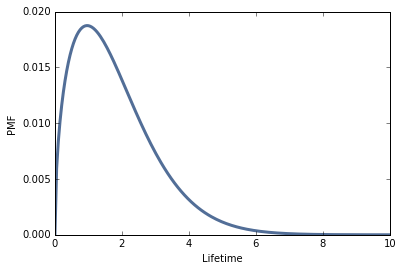

In [7]:
pmf = MakeWeibullPmf(lam, k, high=10)
thinkplot.Pdf(pmf)
thinkplot.Config(xlabel='Lifetime',
                 ylabel='PMF')

We can use np.random.weibull to generate random values from a Weibull distribution with given parameters.

To check that it is correct, I generate a large sample and compare its CDF to the analytic CDF.

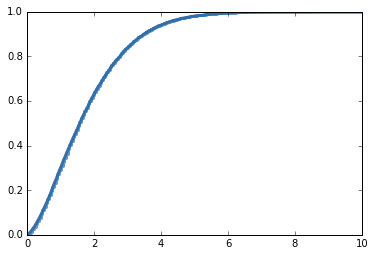

In [8]:
def SampleWeibull(lam, k, n=1):
    return np.random.weibull(k, size=n) * lam

data = SampleWeibull(lam, k, 10000)
cdf = Cdf(data)
model = pmf.MakeCdf()
thinkplot.Cdfs([cdf, model])

**Exercise:** Write a class called `LightBulb` that inherits from `Suite` and `Joint` and provides a `Likelihood` function that takes an observed lifespan as data and a tuple, `(lam, k)`, as a hypothesis.  It should return a likelihood proportional to the probability of the observed lifespan in a Weibull distribution with the given parameters.

Test your method by creating a `LightBulb` object with an appropriate prior and update it with a random sample from a Weibull distribution.

Plot the posterior distributions of `lam` and `k`.  As the sample size increases, does the posterior distribution converge on the values of `lam` and `k` used to generate the sample?

In [9]:
# Solution

class LightBulb(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        lam, k = hypo
        if lam == 0:
            return 0
        x = data
        like = EvalWeibullPdf(x, lam, k)
        return like

In [10]:
# Solution

from itertools import product

lams = np.linspace(0, 5, 101)
ks = np.linspace(0, 5, 101)

suite = LightBulb(product(lams, ks))

In [11]:
# Solution

datum = SampleWeibull(lam, k, 10)
lam = 2
k = 1.5
suite.UpdateSet(datum)

5.5677896093212706e-09

2.3583976257450225

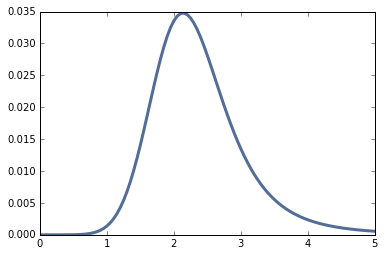

In [12]:
# Solution

pmf_lam = suite.Marginal(0)
thinkplot.Pdf(pmf_lam)
pmf_lam.Mean()

1.2969100506973927

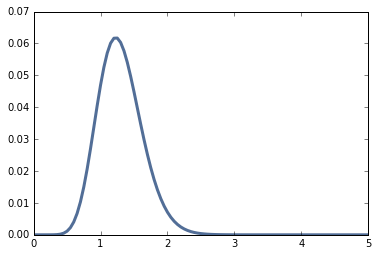

In [13]:
# Solution

pmf_k = suite.Marginal(1)
thinkplot.Pdf(pmf_k)
pmf_k.Mean()

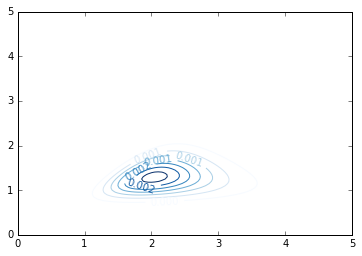

In [14]:
# Solution

thinkplot.Contour(suite)

**Exercise:** Now suppose that instead of observing a lifespan, `k`, you observe a lightbulb that has operated for 1 year and is still working.  Write another version of `LightBulb` that takes data in this form and performs an update. 

In [15]:
# Solution

class LightBulb2(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        lam, k = hypo
        if lam == 0:
            return 0
        x = data
        like = 1 - EvalWeibullCdf(x, lam, k)
        return like

In [16]:
# Solution

from itertools import product

lams = np.linspace(0, 10, 101)
ks = np.linspace(0, 10, 101)

suite = LightBulb2(product(lams, ks))

In [17]:
# Solution

suite.Update(1)

0.83566549505291599

5.6166427208116056

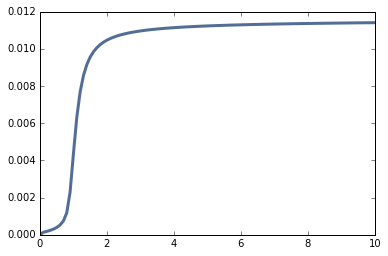

In [18]:
# Solution

pmf_lam = suite.Marginal(0)
thinkplot.Pdf(pmf_lam)
pmf_lam.Mean()

5.2481865102083747

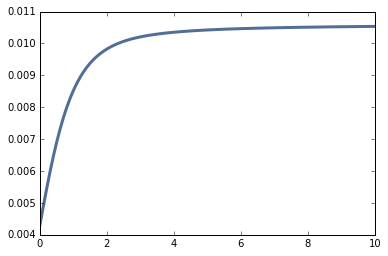

In [19]:
# Solution

pmf_k = suite.Marginal(1)
thinkplot.Pdf(pmf_k)
pmf_k.Mean()

**Exercise:** Now let's put it all together.  Suppose you have 15 lightbulbs installed at different times over a 10 year period.  When you observe them, some have died and some are still working.  Write a version of `LightBulb` that takes data in the form of a `(flag, x)` tuple, where:

1. If `flag` is `eq`, it means that `x` is the actual lifespan of a bulb that has died.
2. If `flag` is `gt`, it means that `x` is the current age of a bulb that is still working, so it is a lower bound on the lifespan.

To help you test, I will generate some fake data.

First, I'll generate a Pandas DataFrame with random start times and lifespans.  The columns are:

`start`: time when the bulb was installed

`lifespan`: lifespan of the bulb in years

`end`: time when bulb died or will die

`age_t`: age of the bulb at t=10

In [20]:
import pandas as pd

lam = 2
k = 1.5
n = 15
t_end = 10
starts = np.random.uniform(0, t_end, n)
lifespans = SampleWeibull(lam, k, n)

df = pd.DataFrame({'start': starts, 'lifespan': lifespans})
df['end'] = df.start + df.lifespan
df['age_t'] = t_end - df.start

df.head()

,lifespan,start,end,age_t
0,2.669393,3.884926,6.554320,6.115074
1,4.439592,1.024761,5.464353,8.975239
2,1.013455,2.801937,3.815392,7.198063
3,1.632849,8.844007,10.476856,1.155993
4,0.774843,8.325410,9.100254,1.674590


Now I'll process the DataFrame to generate data in the form we want for the update.

In [21]:
data = []
for i, row in df.iterrows():
    if row.end < t_end:
        data.append(('eq', row.lifespan))
    else:
        data.append(('gt', row.age_t))
        
for pair in data:
    print(pair)

('eq', 2.6693934023350288)
('eq', 4.4395922794570097)
('eq', 1.0134550944499816)
('gt', 1.1559931554468044)
('eq', 0.7748433201074556)
('eq', 0.58523684453682523)
('eq', 1.5050346559516292)
('eq', 0.0043263460781409529)
('eq', 3.1183238430930049)
('eq', 2.5497343435244648)
('eq', 1.426995199412439)
('eq', 2.8969617422395997)
('eq', 1.2143990874080592)
('gt', 0.28161850035970559)
('eq', 1.4219175345313229)


In [22]:
# Solution

class LightBulb3(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        lam, k = hypo
        if lam == 0:
            return 0
        flag, x = data
        if flag == 'eq':
            like = EvalWeibullPdf(x, lam, k)
        elif flag == 'gt':
            like = 1 - EvalWeibullCdf(x, lam, k)
        else:
            raise ValueError('Invalid data')
        return like

In [23]:
# Solution

from itertools import product

lams = np.linspace(0, 10, 101)
ks = np.linspace(0, 10, 101)

suite = LightBulb3(product(lams, ks))

In [24]:
# Solution

suite.UpdateSet(data)

5.7937515916258046e-12

2.2717545445867739

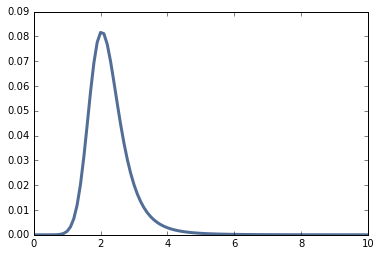

In [25]:
# Solution

pmf_lam = suite.Marginal(0)
thinkplot.Pdf(pmf_lam)
pmf_lam.Mean()

1.2410798895283741

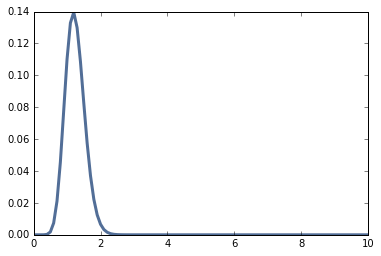

In [26]:
# Solution

pmf_k = suite.Marginal(1)
thinkplot.Pdf(pmf_k)
pmf_k.Mean()

**Exercise:** Suppose you install a light bulb and then you don't check on it for a year, but when you come back, you find that it has burned out.  Extend `LightBulb` to handle this kind of data, too.

In [27]:
# Solution

class LightBulb4(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        lam, k = hypo
        if lam == 0:
            return 0
        flag, x = data
        if flag == 'eq':
            like = EvalWeibullPdf(x, lam, k)
        elif flag == 'gt':
            like = 1 - EvalWeibullCdf(x, lam, k)
        elif flag == 'lt':
            like = EvalWeibullCdf(x, lam, k)
        else:
            raise ValueError('Invalid data')
        return like

## Prediction

**Exercise:** Suppose we know that, for a particular kind of lightbulb in a particular location, the distribution of lifespans is well modeled by a Weibull distribution with `lam=2` and `k=1.5`.  If we install `n=100` lightbulbs and come back one year later, what is the distribution of `c`, the number of lightbulbs that have burned out?

In [28]:
# Solution

# The probability that any given bulb has burned out comes from the CDF of the distribution
p = EvalWeibullCdf(1, lam, k)
p

0.29781149867344037

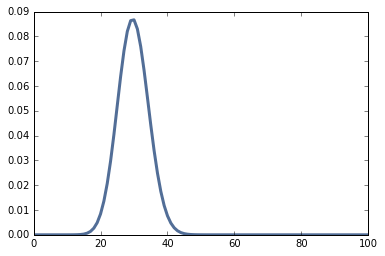

In [29]:
# Solution

# The number of bulbs that have burned out is distributed Binom(n, p)
n = 100
from thinkbayes2 import MakeBinomialPmf

pmf_c = MakeBinomialPmf(n, p)
thinkplot.Pdf(pmf_c)

**Exercise:** Now suppose that `lam` and `k` are not known precisely, but we have a `LightBulb` object that represents the joint posterior distribution of the parameters after seeing some data.  Compute the posterior predictive distribution for `c`, the number of bulbs burned out after one year.

In [30]:
# Solution

n = 100
t_return = 1

metapmf = Pmf()
for (lam, k), prob in suite.Items():
    p = EvalWeibullCdf(t_return, lam, k)
    pmf = MakeBinomialPmf(n, p)
    metapmf[pmf] = prob

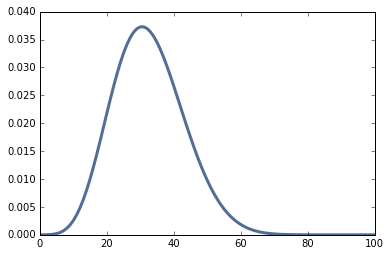

In [31]:
# Solution

from thinkbayes2 import MakeMixture

mix = MakeMixture(metapmf)
thinkplot.Pdf(mix)